# CS-503 Graded Notebook on Transformers

#### Goals:

The goal of this notebook is to familiarize yourself with the following topics:
- Self-attention
- Basic tokenization
- Basic positional encodings
- Transformer encoder-only (e.g. ViT) and decoder-only (e.g. GPT) models
- Vision Transformer (ViT)
- Supervised training
- Autoregressive modelling

This notebook will not cover:
- Cross-attention
- Full transformer encoder+decoder
- Weight initialization techniques
- Stochastic depth, dropout, etc
- Masked or contrastive pre-training
- More advanced tokenization techniques
- Distributed training
- NLP
- Multi-modality
- etc...

This notebook should give you a solid foundation of working with Transformer models and get you "thinking with tokens".

If you want to know more about these topics, please see some of the reading material in the lectures and at the bottom of this notebook, and feel free to ask the TAs.


#### Instructions:

- Your task is to fill in the missing code (denoted by ???), run the training loops and get some results.
- We also ask several open questions. Please limit your answers to 2-3 sentences.
- Submit the notebook with all cells executed.
- We should be able to "Restart Kernel and Run All Cells" and get similar outputs to your solution.
- The notebooks are individual homework.

#### **Submission and due date**: → see Moodle

---

## 1 Setup

We highly recommend running the notebook on a GPU, e.g. by opening it on [Colab](https://colab.research.google.com/).
That said, if you have the patience, you can also run it on regular CPUs or on Apple Silicon (neither is recommended).

### 1.1 Dependencies

We assume you know how to set up Python virtual environments, install packages and use Colab. If not, please come to the exercise session for troubleshooting.

This notebook requires:
- PyTorch & torchvision
- einops
- matplotlib
- tqdm

In [ ]:
# Dependencies. If you already have them installed, no need to run this cell.
!pip install torch torchvision einops matplotlib tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tqdm.auto import tqdm
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import MNIST
from einops import rearrange, repeat
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

if torch.cuda.is_available():
    device = torch.device('cuda')
    !nvidia-smi
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
    
print('Selected device:', device)

Sun Mar 19 10:00:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    28W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 1.2 Data

To reduce the computational cost of running this notebook, we'll operate on downsized 14x14 MNIST images. 
Even though we will only work on toy problems, the principles shown in this notebook are very similar to, if not the same in real-world models.

In [ ]:
image_size = 14
batch_size = 64
num_workers = 10

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((image_size, image_size)),
    torchvision.transforms.ToTensor()
])

dataset_train_val = MNIST(root='./data', train=True, download=True, transform=transform)
dataset_train, dataset_val = torch.utils.data.random_split(dataset_train_val, [50_000, 10_000])
dataset_test = MNIST(root='./data', train=False, download=True, transform=transform)

loader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, num_workers=num_workers, drop_last=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, num_workers=num_workers, drop_last=False)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
dataset_train[0][0].shape

torch.Size([1, 14, 14])

Let's look at some images from the training set (it's just good old MNIST):

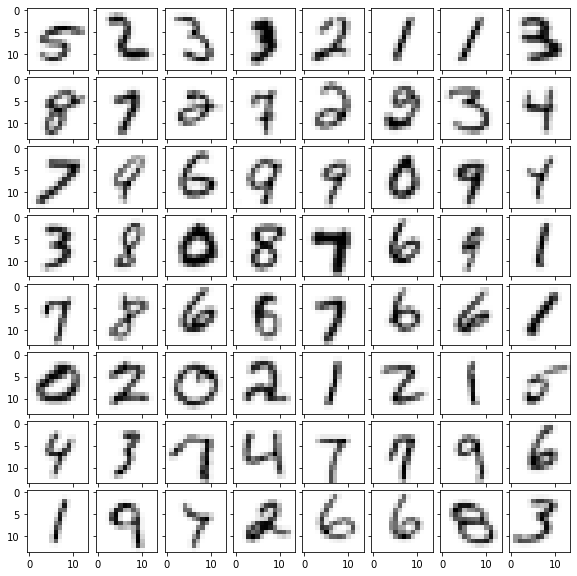

In [ ]:
imgs, cls_idxs = next(iter(loader_train))

fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111, nrows_ncols=(8, 8), axes_pad=0.1)
for i, img in enumerate(imgs):
    grid[i].imshow(img[0], cmap='Greys')
plt.show()

---

## 2 Image classification with a Vision Transformer (ViT)

We will now implement a simple [ViT](https://arxiv.org/abs/2010.11929) and perform digit classification on MNIST.

![Vision Transformer](https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png)

Remember that a ViT is a Transformer encoder, which consists of several stacked blocks of self-attention and MLPs. 
We will first implement the MLP and self-attention, which can then be assembled into a Transformer encoder block.
Afterwards, we will look at positional embeddings and the patching operation to turn images into sequences of tokens.

![Transformer encoder](https://www.researchgate.net/publication/334288604/figure/fig1/AS:778232232148992@1562556431066/The-Transformer-encoder-structure.ppm)

Please consult the [Attention Is All You Need](https://arxiv.org/abs/1706.03762) and [ViT](https://arxiv.org/abs/2010.11929) papers, as well as the reading material at the bottom of this notebook and the course slides, should you require further details.

### 2.1 MLP layer (10 pts)

In the following cell, implement the following two-layer Perceptron:

$$ \text{MLP}(X) = \text{GeLU}(X W_1^T + b_1) W_2^T + b_2 $$

Here, $\text{GeLU}$ denotes the [GeLU activation function](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html). 
The first linear layer projects x from dimension `dim` to `int(mlp_ratio * dim)`, while the second projects it back to `dim`.

In [ ]:
class Mlp(nn.Module):
    def __init__(self, dim, mlp_ratio=4.):
        super().__init__()
        
        # TODO
        self.gelu_ = nn.GELU()    
        self.linear_1 = nn.Linear(dim, int(mlp_ratio * dim))
        self.linear_2 = nn.Linear(int(mlp_ratio * dim), dim)    

    def forward(self, x):
        
        # TODO
        return self.linear_2(self.gelu_(self.linear_1(x)))

### 2.2 (Masked) self-attention layer (20 pts)

Next, we ask you to implement a layer that performs (optionally masked) multi-headed self-attention.

Remember the scaled dot-product attention formula seen in the course:
$$ \text{Attention}(Q, K, V) = \text{softmax}_\text{row} \left( \frac{Q K^T}{\sqrt{d_k}} \right) V $$

The queries $Q$, the keys $K$, and the values $V$ are all linear projections of $X$:

$$ Q(X) = X W_Q^T $$
$$ K(X) = X W_K^T $$
$$ V(X) = X W_V^T $$

The scaling factor $d_k$ is the dimensionality of the keys $K$, i.e. `dim // num_heads`.

The attention is performed on `num_heads` heads in parallel (don't use a for loop) in `dim // num_heads`-dimensional subspaces and the results are concatenated along the feature dimension.

In addition, we want to enable masking of the attention matrix, e.g. for implementing a Transformer decoder.
For this, the forward function takes an additional `mask` argument, specifying where to zero-out the attention matrix.
In practice, this is implemented by replacing the values of the attention matrix (pre softmax) to minus infinity wherever we don't want any attention flow.

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8):
        '''
        Self-attention layer.
        
        params:
            :dim: Dimensionality of each token
            :num_heads: Number of attention heads
        '''
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        # TODO: Define here the linear layers producing K, Q, V from the input x
        self.query = nn.Linear(dim, num_heads * head_dim)
        self.key = nn.Linear(dim, num_heads * head_dim)
        self.value = nn.Linear(dim, num_heads * head_dim)

        # Projection
        self.proj = nn.Linear(num_heads * head_dim, dim)

    def forward(self, x, mask=None):
        '''
        Performs a forward pass through the multi-headed self-attention layer.
        
        params:
            :x: Input of shape [B N C]. B = batch size, N = sequence length, C = token dimensionality
            :mask: Optional attention mask of shape [B N N]. Wherever it is True, the attention matrix will
            be zero.
            
        returns:
            Output of shape [B N C].
        '''
        B, N, C = x.shape
        
        # TODO: Compute the keys K, queries Q, and values V from x. Each should be of shape [B num_heads N head_dim].
        # q, k, v = self.query(x), self.key(x), self.value(x)
        q = rearrange(self.query(x), "B N (num_heads head_dim) -> B num_heads N head_dim", num_heads=self.num_heads)
        k = rearrange(self.key(x), "B N (num_heads head_dim) -> B num_heads N head_dim", num_heads=self.num_heads)
        v = rearrange(self.value(x), "B N (num_heads head_dim) -> B num_heads N head_dim", num_heads=self.num_heads)

        # print("q.shape:", q.shape)

        # breakpoint()
        # TODO: Compute the attention matrix (pre softmax) and scale it by 1/sqrt(d_k). It should be of shape [B num_heads N N].
        # Take the dot product between "query" and "key" to get the raw attention scores.
        attn = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        if mask is not None:
            # TODO: Apply the optional attention mask. Wherever the mask is True, replace the attention matrix value by negative infinity → zero attention weight after softmax.
            mask = rearrange(mask, "b n1 n2 -> b 1 n1 n2")
            mask = (mask == False) # Convert mask to boolean and negate it
            attn = attn.masked_fill(mask, float('-inf')) # Replace masked values with negative infinity

        # TODO: Compute the softmax over the last dimension
        attn = nn.functional.softmax(attn, dim=-1)

        # TODO: Weight the values V by the attention matrix and concatenate the different attention heads
        x = torch.matmul(attn, v)
        x = rearrange(x, "B num_heads N head_dim -> B N (num_heads head_dim)")

        # One final projection
        x = self.proj(x)
        return x

### 2.3 Open ended question on attention (10 pts)

#### Question:
What are the main differences between self-attention and convolutions?

#### Answer:

1- In convolutions with a $ K\times K $ kernel size, the receptive field is limited only to a $ K \times K$ neighborhood grid. In contrast, in self attension, the receptive field is the full image, since the values of every other pixel in the image, has a contribution to the new value of a pixel.
[reference: https://doi.org/10.48550/arXiv.1911.03584]

2- The self attention, inherently does not care about the ordering of the sequence and will always produce the same output, regardless of the order of the elements in the input sequence. This is why we add positional embeddings to the input sequence which are learned throughout training. [reference: https://doi.org/10.48550/arXiv.1911.03584]

3- CNNs are typically used for inputs that have an inherent spatial relationship in them, such as images. However, self-attentions can be used for other types of inputs that do not have this property, such as texts.

4- It is easier to interpret the weights of CNN as they are designed to learn the local (kernel neighborhood) relationships in the images. 

### 2.4 Transformer encoder block (10 pts)

In the next cell, implement a Transformer block. It is defined as:

$$ X_a = X + \text{Attention}(\text{LN}(X)) $$
$$ X_b = X_a + \text{MLP}(\text{LN}(X_a)) $$

Here, $\text{LN}$ denotes two LayerNorm layers.

Don't forget to pass the optional mask to the self-attention layer!

In [ ]:
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.):
        '''
        Transformer encoder block.
        
        params:
            :dim: Dimensionality of each token
            :num_heads: Number of attention heads
            :mlp_ratio: MLP hidden dimensionality multiplier
        '''
        super().__init__()

        # TODO
        self.attention = Attention(dim, num_heads)
        self.mlp = Mlp(dim, mlp_ratio)
        self.layernorm_1 = nn.LayerNorm(dim)
        self.layernorm_2 = nn.LayerNorm(dim)


    def forward(self, x, mask=None):
        '''
        Performs a forward pass through the multi-headed self-attention layer.
        
        params:
            :x: Input of shape [B N C]. B = batch size, N = sequence length, C = token dimensionality
            :mask: Optional attention mask of shape [B N N]. Wherever it is True, the attention matrix will
            be zero.
            
        returns:
            Output of shape [B N C].
        '''
        # TODO
        # Multi-Headed Self-Attention
        residual = x
        x = self.layernorm_1(x)
        x = self.attention(x, mask)
        x = x + residual
        
        # Feedforward MLP
        residual = x
        x = self.layernorm_2(x)
        x = self.mlp(x)
        x = x + residual

        return x
        

### 2.5 Patch embedding layer (10 pts)

So far, we implemented everything needed to build a vanilla Transformer encoder and we could more or less directly use it to train e.g. a [BERT](https://arxiv.org/abs/1810.04805) model.
If we want to use it for images, we first have to turn these images into sequences of tokens (since that's what Transformers operate on).
If we were to do this naively and simply flatten an HxWxC image into (H * W) C-dimensional tokens, we quickly run into difficulties...
Even moderately-sized images would result in massive sequence lengths. Let's say our images have size 224x224. Then, our sequence length would be 50'176. Given how the cost of self-attention scales quadratically with the sequence length, we need to find another solution.

We can address this problem by spending a little bit of compute and using the implicit bias of image-like data that neighboring pixels are often highly correlated. 
[Vision Transformers](https://arxiv.org/abs/2010.11929) split images into patches (e.g. of size 16x16) and then linearly project each of them to the desired token dimension.
The same 224x224 image from before would be turned into 14x14 patches, each of size 16x16x3, flattened to 768-dimensional vectors.
Each of these vectors is then linearly projected to the token dimension of the Transformer.

In the next cell, your task is to implement the patching + patch-wise linear projection operation.

Hint: Can you perform this operation with a single Conv2d layer? Using einops can yield an alternative and elegant solution as well.

In [ ]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=14, patch_size=2, in_channels=1, embed_dim=192):
        '''
        Image to Patch Embedding.
        
        params:
            :img_size: Image height and width in pixels
            :patch_size: Patch size height and width in pixels
            :in_channels: Number of input channels
            :embed_dim: Token dimension
        '''
        super().__init__()
        
        # TODO
        self.projection = nn.Conv2d(in_channels=in_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        '''
        Performs a forward pass through the patch embedding.
        
        params:
            :x: Input of shape [B C H W]. B = batch size, C = number of channels, H = image height, W = image width
            
        returns:
            Output of shape [B N C].
        '''
        
        # TODO
        embeddings = self.projection(x).flatten(2).transpose(1, 2)
        return embeddings


### 2.6 Positional embeddings

Attention is a permuation invariant operation for keys and values, and equivariant for queries, meaning that if we don't "tag" each token with some positional information, the Transformer would have no way of keeping track of where some piece of information comes from and goes to.
We can add this positional information by summing to each token a unique positional embedding.
Should this information be useful for the task, then the Transformer can "choose" to propagate it throughout the layers and keep track of it.

Just like the tokenization, positional embeddings depend on the type of data too. 
If we deal with sequences like text, 1-dimensional embeddings can be either hardcoded, or learned end-to-end.

Here are examples of common sine-cosine positional embeddings in both 1D and 2D:

In [ ]:
def build_1d_sincos_posemb(max_len, embed_dim=1024, temperature=10000.):
    """Sine-cosine positional embeddings from MoCo-v3, adapted back to 1d
    Returns positional embedding of shape [1, N, D]
    """
    arange = torch.arange(max_len, dtype=torch.float32)
    assert embed_dim % 2 == 0, 'Embed dimension must be divisible by 2 for 1D sin-cos position embedding'
    pos_dim = embed_dim // 2
    omega = torch.arange(pos_dim, dtype=torch.float32) / pos_dim
    omega = 1. / (temperature ** omega)
    out = torch.einsum('m,d->md', [arange, omega])
    pos_emb = torch.cat([torch.sin(out), torch.cos(out)], dim=1)[None, :, :]
    return pos_emb

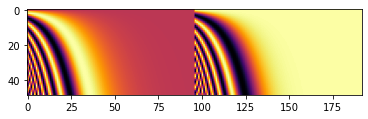

In [ ]:
# Sequence length 49, with token dimensionality 192
plt.imshow(build_1d_sincos_posemb(49,192)[0], cmap='inferno')

In [ ]:
def build_2d_sincos_posemb(h, w, embed_dim=1024, temperature=10000.):
    """Sine-cosine positional embeddings from MoCo-v3
    Source: https://github.com/facebookresearch/moco-v3/blob/main/vits.py
    Returns positional embedding of shape [B, N, D]
    """
    grid_w = torch.arange(w, dtype=torch.float32)
    grid_h = torch.arange(h, dtype=torch.float32)
    grid_w, grid_h = torch.meshgrid(grid_w, grid_h)
    assert embed_dim % 4 == 0, 'Embed dimension must be divisible by 4 for 2D sin-cos position embedding'
    pos_dim = embed_dim // 4
    omega = torch.arange(pos_dim, dtype=torch.float32) / pos_dim
    omega = 1. / (temperature ** omega)
    out_w = torch.einsum('m,d->md', [grid_w.flatten(), omega])
    out_h = torch.einsum('m,d->md', [grid_h.flatten(), omega])
    pos_emb = torch.cat([torch.sin(out_w), torch.cos(out_w), torch.sin(out_h), torch.cos(out_h)], dim=1)[None, :, :]
    return pos_emb

/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


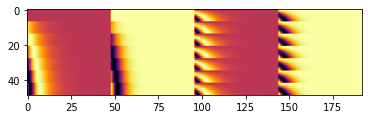

In [ ]:
# Sequence length 49 (= 7x7 patches), with token dimensionality 192
plt.imshow(build_2d_sincos_posemb(7,7,192)[0], cmap='inferno')

### 2.7 Assembling the blocks into a ViT (10 pts)

Now we have all the building blocks to create a ViT! 

Implement the following operations:
- Turning images into patches and projecting them to the token dimension
- Adding positional embeddings to the tokens
- Running the tokens through all Transformer blocks
- Taking the mean over all tokens of each batch and projecting to logits

In [ ]:
class ViT(nn.Module):
    
    def __init__(self, 
                 img_size=14, 
                 patch_size=2, 
                 in_channels=1, 
                 embed_dim=192, 
                 num_classes=10, 
                 depth=4, 
                 num_heads=4, 
                 mlp_ratio=4., 
                 **kwargs):
        '''
        A Vision Transformer for classification.
        
        params:
            :img_size: Image height and width in pixels
            :patch_size: Patch size height and width in pixels
            :in_channels: Number of input channels
            :embed_dim: Token dimension
            :num_classes: Number of classes
            :depth: Transformer depth
            :num_heads: Number of attention heads
            :mlp_ratio: MLP hidden dimensionality multiplier
        '''
        super().__init__()
        
        self.patch_embed = PatchEmbed(img_size, patch_size, in_channels, embed_dim)
        self.pos_embed = nn.Parameter(
            build_2d_sincos_posemb(img_size//patch_size, img_size//patch_size, embed_dim=embed_dim), 
            requires_grad=False
        )
        
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio)
            for i in range(depth)
        ])
        self.head = nn.Linear(embed_dim, num_classes, bias=False)
            
    def forward(self, x):
        '''
        Forward pass through the ViT.
        
        params:
            :x: Input of shape [B C H W]. B = batch size, C = number of channels, H = image height, W = image width
            
        returns:
            Output of shape [B num_classes]
        '''        
        # TODO: Project images to patches
        x = self.patch_embed(x) # x.shape: [64, 49, 192]
        
        # TODO: Add the positional embeddings to the tokens
        x = x + self.pos_embed # self.pos_embed.shape: [1, 49, 192]

        # TODO: Forward pass through Transformer blocks
        for block in self.blocks:
          x = block(x)
            
        # TODO: Perform average pooling (compute the mean over the sequences)
        x = x.mean(dim=1)
        
        # TODO: Compute the logits
        logits = self.head(x)
        
        return logits

### 2.8 Training the ViT for digit classification

Finally, let's train a very small ViT on MNIST. Here's a simple training loop that should only take 5-10 minutes on a V100 or Tesla T4 GPU:

In [ ]:
vit = ViT(
    img_size=14, patch_size=2, in_channels=1, 
    embed_dim=192, num_classes=10, depth=4, 
    num_heads=4, mlp_ratio=4., 
).to(device)
optimizer = torch.optim.AdamW(vit.parameters())
num_parameters = sum([p.numel() for p in vit.parameters()])
print(f'Number of parameters: {num_parameters:,}')

Number of parameters: 1,791,744


In [ ]:
num_epochs = 20

train_losses = []
val_losses = []

for _ in range(num_epochs):
    
    # Train loop
    vit.train()
    epoch_loss_train = 0
    pbar = tqdm(total=len(loader_train))
    for imgs, cls_idxs in loader_train:
        inputs, targets = imgs.to(device), cls_idxs.to(device)

        logits = vit(inputs)
        loss = F.cross_entropy(logits, targets)

        vit.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        epoch_loss_train += loss.item()
        
        pbar.update(1)
        pbar.set_description(f'Train loss: {loss.item():.3f}')
    pbar.close()
    
    epoch_loss_train /= len(loader_train)
    train_losses.append(epoch_loss_train)
    
    
    # Validation loop
    vit.eval()
    epoch_loss_val = 0
    for imgs, cls_idxs in loader_val:
        inputs, targets = imgs.to(device), cls_idxs.to(device)

        with torch.no_grad():
            logits = vit(inputs)
        loss = F.cross_entropy(logits, targets)
        
        epoch_loss_val += loss.item()
    
    epoch_loss_val /= len(loader_val)
    val_losses.append(epoch_loss_val)
    
    print(f'Train loss: {epoch_loss_train:.3f}, val loss: {epoch_loss_val:.3f}')

  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.604, val loss: 0.270


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.198, val loss: 0.186


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.171, val loss: 0.150


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.138, val loss: 0.149


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.131, val loss: 0.157


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.122, val loss: 0.114


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.111, val loss: 0.094


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.109, val loss: 0.111


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.099, val loss: 0.099


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.095, val loss: 0.129


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.093, val loss: 0.118


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.086, val loss: 0.113


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.080, val loss: 0.106


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.078, val loss: 0.081


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.067, val loss: 0.085


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.076, val loss: 0.107


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.065, val loss: 0.075


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.061, val loss: 0.089


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.068, val loss: 0.074


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.057, val loss: 0.085


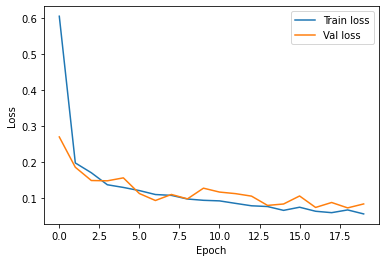

In [ ]:
plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_loss = 0
correct = 0

vit.eval()
for imgs, cls_idxs in loader_test:
    inputs, targets = imgs.to(device), cls_idxs.to(device)

    with torch.no_grad():
        logits = vit(inputs)
    loss = F.cross_entropy(logits, targets)
    test_loss += loss.item()
    
    pred = logits.argmax(dim=1, keepdim=True)
    correct += pred.eq(targets.view_as(pred)).sum().item()

test_loss /= len(loader_test)
accuracy = correct / len(loader_test.dataset)

print(f'Test loss: {test_loss:.3f}')
print(f'Test top-1 accuracy: {accuracy*100}%')

Test loss: 0.073
Test top-1 accuracy: 97.85000000000001%


For reference, we get over 97% top-1 test set accuracy with this simple training loop over 20 epochs. Some stochasticity around that value is expected, but if you're far below, check your implementation again.

### 2.9 Open ended question on Vision Transformers (10 pts)¶

#### Question:
This ViT was designed for image classificaton. How could we modify it for solving dense prediction tasks, such as pixel-wise depth estimation or semantic segmentation?

#### Answer:
In ViT, in order to to classification, we use a feed-forward classification head which maps the hidden state to class logits. For dense prediction tasks we have to modify this head such that it maps the hidden state to an appropriate output. For instance, for pixel-wise depth estimation, the head should map the hidden state to pixel_wise depths. In semantic segmenention, the head should map the hidden state to image segments in a suitable way.

Moreover, at in ViT because we are doing classification, we either use the \<cls\> token encoding as the input of the classification head, or if we are not using the \<csl\> token, we do some kind of pooling such as averge pooling across all the encodings as the input for classification head. However, for dense prediction tasks, we might have have to use all the encodings as the input of the head prediction layer. For example for the pixel-wise depth estimation task, we should use the encodings of all the pixel tokens as the input to the prediction head.

Also, in pixel-wise depth estimatin task, as we want to predict the depth for all the pixels, we cannot perform batch down sampling on the inputs, as we would lose pixel-wise information.

---

## 3 Image generation with GPT

In this part, we will implement a GPT model and train it on images, similar in spirit to [iGPT](https://openai.com/research/image-gpt).
What this means is that we turn images into a sequence of discrete tokens and train a decoder-only Transformer to perform next-token-prediction.
At inference time, we can then autoregressively generate new images from the training distribution!

### 3.1 Tokenization

First, we need to turn images into sequences of discrete tokens.

A common way of performing tokenization of images is to train a discrete VAE, such as (VQ-GAN)[https://arxiv.org/abs/2012.09841] to autoencode images through a discrete bottleneck.
Since we don't want to open that can of worms in a homework about Transformers, we can instead suggest you to check this out in your own time.

Here, we will tokenize the images in a much simpler way:
- First, we turn the grayscale images into black and white → each image is now a sequence of 14x14 zeros and ones. In this manner, we would already have a sequence of discrete tokens we could model, but the sequence length of 14x14=192 could be shorter.
- To reduce the sequence length further, we divide the image into 2x2 patches and turn each of the 2x2 patterns into a unique index. If we flatten each 2x2 patch into a sequence of 4 zeros and ones, we can directly interpret them as integers between 0 and 15. This reduces the sequence length by a factor of four. Much more manageable in our toy setting!

While this way of tokenizing is really quite "toy", it is indicative of a common problem when dealing with images and transformers: naively turning images to tokens can result in very large sequence lengths, which do not go well with the quadratic complexity of self-attention.

In [ ]:
def dec2bin(x, bits):
    mask = 2 ** torch.arange(bits - 1, -1, -1).to(x.device, x.dtype)
    return x.unsqueeze(-1).bitwise_and(mask).ne(0).float()

def bin2dec(b, bits):
    mask = 2 ** torch.arange(bits - 1, -1, -1).to(b.device, b.dtype)
    return torch.sum(mask * b, -1).long()

def tokenize_MNIST(imgs, patch_size=2):
    imgs = (imgs[:,0] > 0.5).int()
    bits = rearrange(
        imgs, 
        'b (nh ph) (nw pw) -> b (nh nw) (ph pw)', 
        ph=patch_size, pw=patch_size
    )
    return bin2dec(bits, patch_size**2)

def detokenize_MNIST(imgs_tokenized, patch_size=2):
    bits = dec2bin(imgs_tokenized, patch_size**2)
    N = int(math.sqrt(imgs_tokenized.shape[-1]))
    return rearrange(
        bits, 
        'b (nh nw) (ph pw) -> b (nh ph) (nw pw)', 
        ph=patch_size, pw=patch_size, nh=N, nw=N
    )

Here are some examples of tokenized images:

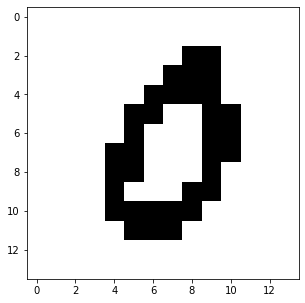

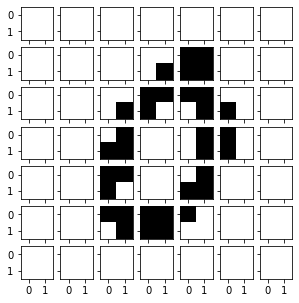

Tokens: tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 15,  0,  0,  0,  0,  1, 14,
        13,  2,  0,  0,  0,  7,  0,  5, 10,  0,  0,  0, 14,  0,  7,  0,  0,  0,
         0, 13, 15,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0]) 




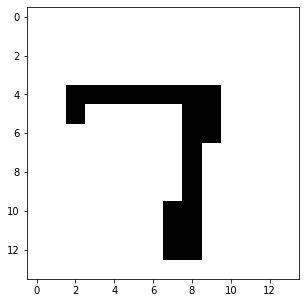

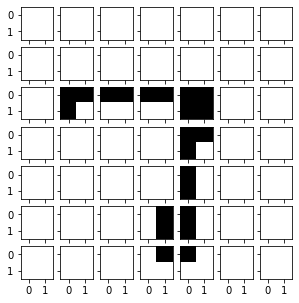

Tokens: tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14, 12, 12,
        15,  0,  0,  0,  0,  0,  0, 14,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,
         0,  0,  5, 10,  0,  0,  0,  0,  0,  4,  8,  0,  0]) 




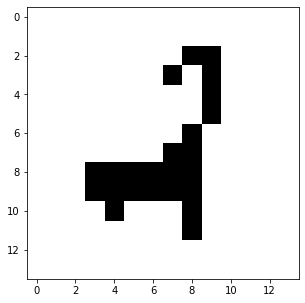

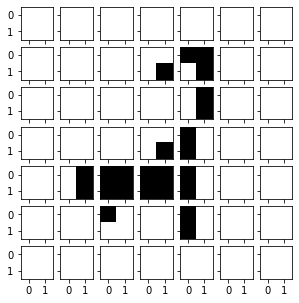

Tokens: tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1, 13,  0,  0,  0,  0,  0,  0,
         5,  0,  0,  0,  0,  0,  1, 10,  0,  0,  0,  5, 15, 15, 10,  0,  0,  0,
         0,  8,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0]) 




In [ ]:
imgs, _ = next(iter(loader_train))

tokens = tokenize_MNIST(imgs, patch_size=2)
reconst = detokenize_MNIST(tokens, patch_size=2)
bits = rearrange(reconst, 'b (nh ph) (nw pw) -> b (nh nw) ph pw', ph=2, pw=2)

for i in range(3):
    plt.figure(figsize=(5., 5.)); plt.imshow(reconst[i], cmap='Greys'); plt.show()
    
    fig = plt.figure(figsize=(5., 5.))
    grid = ImageGrid(fig, 111, nrows_ncols=(7, 7), axes_pad=0.1)
    for j, img in enumerate(bits[i]):
        grid[j].imshow(img, cmap='Greys', vmin=0, vmax=1)
    plt.show()
    
    print('Tokens:', tokens[i], '\n\n')

### 3.4 GPT implementation (20 pts)

In the next cell, implement a GPT model. Specifically, implement the following:
- Embed the token indices into the desired Transformer token dimension
- Add to each token a unique positional embedding
- Create a causal mask that restricts the self-attention to the same and previous tokens
- Run the tokens through the Transformer blocks
- Compute per-token logits

In [ ]:
class GPT(nn.Module):
    def __init__(self, max_tokens=49+1, vocab_size=16+2, embed_dim=192, depth=4, num_heads=4, mlp_ratio=4., **kwargs):
        '''
        GPT to autoregressively model sequences.
        
        params:
            :max_tokens: Maximum sequence length (should include start-of-sequence token)
            :vocab_size: Vocabulary size (should include start-of-sequence and end-of-sequence token)
            :embed_dim: Token dimension
            :depth: Transformer depth
            :num_heads: Number of attention heads
            :mlp_ratio: MLP hidden dimensionality multiplier
        '''
        super().__init__()
        
        self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        # For simplicity, we will use a 1D positional embedding here, even though the data is 2D.
        self.pos_embed = nn.Parameter(build_1d_sincos_posemb(max_tokens, embed_dim=embed_dim), requires_grad=False)
        
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio)
            for i in range(depth)
        ])
        self.head = nn.Linear(embed_dim, vocab_size, bias=False)
            
    def forward(self, x):
        '''
        Forward pass through the GPT.
        
        params:
            :x: Input of shape [B N]. B = batch size, N = sequence length
            
        returns:
            Output of shape [B N vocab_size]
        '''
        B, N = x.shape
        
        # TODO: Embed the input x
        # print(B, N)
        x = self.embed(x)
        
        # TODO: Add to x the positional embeddings. Make sure to deal with the case, where N is smaller than the maximum sequence length.
        x = x + self.pos_embed[:, :N, :]
        # print(self.pos_embed.shape)
        
        # TODO: Create a causal mask of shape [B N N]. The mask should set values in the attention matrix 
        # to zero, such that tokens can only attend to previous tokens or themselves, but not at "future" tokens.
        mask = torch.tril(torch.ones(B, N, N)).bool().to(device) # ??? device necessary?
        
        # TODO: Forward pass through Transformer blocks. Make sure to pass the causal mask.
        for block in self.blocks:
          x = block(x, mask=mask)
            
        # TODO: Compute the logits for each token
        logits = self.head(x)
        
        return logits
    
    @torch.no_grad()
    def generate(self, seq, max_new_tokens, temperature=1.0, do_sample=True, top_k=None):
        '''
        Given a start sequence, generate the remaining tokens.
        
        params:
            :seq: Input sequence of shape [B n]. To generate samples from scratch, pass a [B 1] tensor full of the "start sequence" token.
            :max_new_tokens: Number of tokens to generate
            :temperature: Sample tokens with the desired temperature
            :do_sample: Set to True to sample and False for simply picking the most likely token
            :top_k: Optionally restrict the logits to top k options
        '''
        for _ in range(max_new_tokens):
            logits = self(seq)
             # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # either sample from the distribution or take the most likely element
            if do_sample:
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                _, idx_next = torch.topk(probs, k=1, dim=-1)
            # append sampled index to the running sequence and continue
            seq = torch.cat((seq, idx_next), dim=1)
            
        return seq

### 3.5 Train iGPT

Let's train the GPT on MNIST and generate some samples!
We prepend every sequence with a start-of-sequence token and append an end-of-sequence token.
We train the Decoder-only transformer to predict a shifted version of the input and thanks to the causal mask, tokens can only attend to previous tokens and themselves.

Don't worry if not all of the generated images look like MNIST digits, though most of them should look somewhat plausible.

In [ ]:
patch_size = 2
vocab_size = 2**(patch_size*patch_size)
max_tokens = (image_size//patch_size)**2

gpt = GPT(
    max_tokens=max_tokens+1, # number of tokens for one image + one for start-of-sequence token
    vocab_size=vocab_size+2, # two additional vocabulary items for start-of-sequence and end-of-sequence token
    embed_dim=192, 
    depth=4, 
    num_heads=4, 
    mlp_ratio=4.
).to(device)
optimizer = torch.optim.AdamW(gpt.parameters())

In [ ]:
num_epochs = 10

train_losses = []
val_losses = []

start_of_seq_token = vocab_size
end_of_seq_token = vocab_size+1

for _ in range(num_epochs):
    
    # Train loop
    vit.train()
    epoch_loss_train = 0
    pbar = tqdm(total=len(loader_train))
    for imgs, _ in loader_train:
        x = tokenize_MNIST(imgs, patch_size=patch_size).to(device)
        inputs = torch.nn.functional.pad(x.clone(), (1,0,0,0), value=start_of_seq_token)
        targets = torch.nn.functional.pad(x.clone(), (0,1,0,0), value=end_of_seq_token)

        logits = gpt(inputs)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        gpt.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
        epoch_loss_train += loss.item()
        
        pbar.update(1)
        pbar.set_description(f'Train loss: {loss.item():.3f}')
    pbar.close()
    
    epoch_loss_train /= len(loader_train)
    train_losses.append(epoch_loss_train)
    
    
    # Validation loop
    vit.eval()
    epoch_loss_val = 0
    for imgs, _ in loader_val:
        x = tokenize_MNIST(imgs, patch_size=patch_size).to(device)
        inputs = torch.nn.functional.pad(x.clone(), (1,0,0,0), value=start_of_seq_token)
        targets = torch.nn.functional.pad(x.clone(), (0,1,0,0), value=end_of_seq_token)

        with torch.no_grad():
            logits = gpt(inputs)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        
        epoch_loss_val += loss.item()
    
    epoch_loss_val /= len(loader_val)
    val_losses.append(epoch_loss_val)
    
    print(f'Train loss: {epoch_loss_train:.3f}, val loss: {epoch_loss_val:.3f}')

  0%|          | 0/781 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train loss: 0.618, val loss: 0.535


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.526, val loss: 0.520


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.512, val loss: 0.508


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.504, val loss: 0.505


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.498, val loss: 0.502


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.494, val loss: 0.499


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.500, val loss: 0.496


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.484, val loss: 0.497


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.481, val loss: 0.497


  0%|          | 0/781 [00:00<?, ?it/s]

Train loss: 0.478, val loss: 0.495


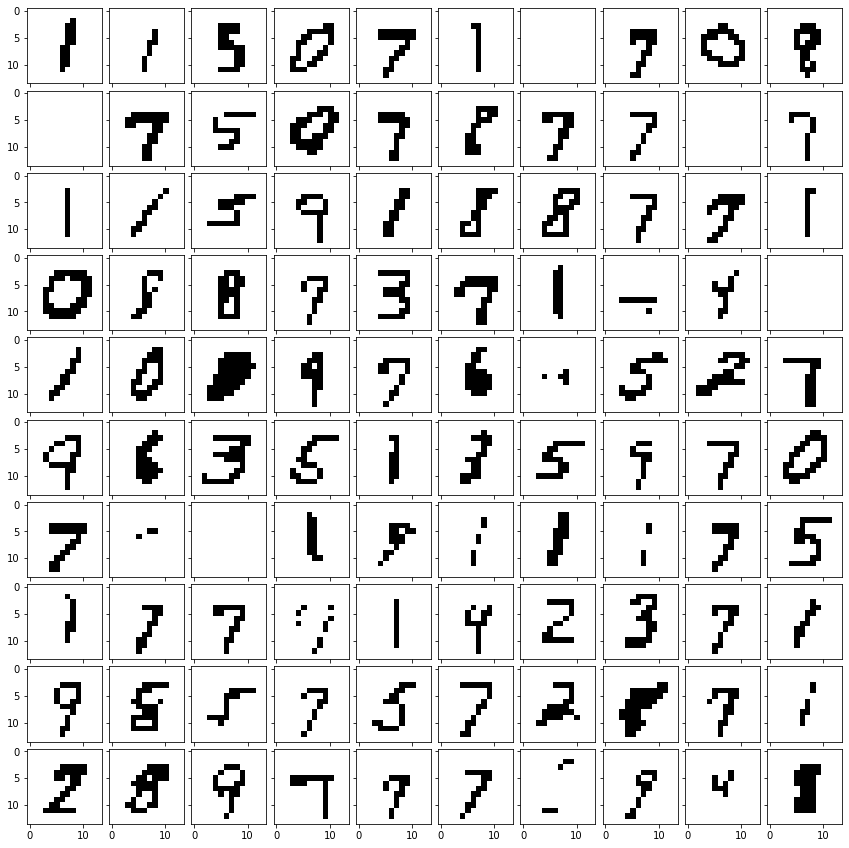

In [ ]:
seq = repeat(torch.LongTensor([[start_of_seq_token]]).to(device), '1 d -> n d', n=100)
gen_seq = gpt.generate(seq, 49, temperature=0.7, do_sample=True).detach().cpu()
reconst = detokenize_MNIST(gen_seq[:,1:], patch_size=patch_size)

fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111, nrows_ncols=(10, 10), axes_pad=0.1)
for i in range(100):
    grid[i].imshow(reconst[i], cmap='Greys')
plt.show()

## 5 Further reading

Having implemented self-attention, as well as encoder-only and decoder-only Transformers, you should not have a hard time implementing cross-attention and a full encoder-decoder Transformer to train on arbitrary sequence-to-sequence tasks.
That said, here is some further reading material should you want to dive deeper.

### Papers & Blogs

- [Attention Is All You Need, Vaswani et al. 2017](https://arxiv.org/abs/1706.03762)
- [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale, Dosovitskiy et al. 2020](https://arxiv.org/abs/2010.11929)
- [DeiT III: Revenge of the ViT](https://arxiv.org/abs/2204.07118) → a more modern and simplified training recipe for supervised ViTs
- [Transformer Circuits Thread](https://transformer-circuits.pub/)
- [The Transformer Family Version 2.0, Lilian Weng 2023](https://lilianweng.github.io/posts/2023-01-27-the-transformer-family-v2/)
- [The Illustrated Transformer, Jay Alammar 2018](https://jalammar.github.io/illustrated-transformer/)

### Code bases

If you want to use transformers in your project, we recommend taking a look at the following codebases:
- [Self-Supervised Vision Transformers with DINO](https://github.com/facebookresearch/dino)
- [Masked Autoencoders Are Scalable Vision Learners (MAE)](https://github.com/facebookresearch/mae)

You might find that, in many ways, these repos are not that much different from what we implemented here!